# Finetune EfficientNet-B5


## efficientnetb5_1080repetitive_2


With 1920x1080 repetitive-padded melspectrogram images without data augmentation

Instead of unfreezing just 3 layers, we unfreeze 5 layers


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnetb5_1080repetitive_2'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b5(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 5 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-5, -4, -3, -2, -1]:  # Use negative indices to target the last 5 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 456x456, suitable for EfficientNet-B5
    transforms.Resize((456, 456)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_33028\2770681902.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=32,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=32,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=32,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 297/297 [01:17<00:00,  3.82it/s, Loss=0.4628285765647888, Elapsed=88.1153s, ETA=0.0000s]  


Epoch 1 completed in 1400.3897s
Train Loss: 0.9366526166367979 - Train Accuracy: 62.18086429524434
Validation Loss: 0.845251808313007 - Validation Accuracy: 66.19881806669481

Epoch 2/50


Validating: 100%|██████████| 297/297 [01:17<00:00,  3.86it/s, Loss=0.14276191592216492, Elapsed=87.3886s, ETA=0.0000s] 


Epoch 2 completed in 1395.6932s
Train Loss: 0.697635217821805 - Train Accuracy: 71.83012595825514
Validation Loss: 0.7065113617314233 - Validation Accuracy: 73.34318277754328

Epoch 3/50


Validating: 100%|██████████| 297/297 [01:16<00:00,  3.86it/s, Loss=0.01589789055287838, Elapsed=87.3940s, ETA=0.0000s] 


Epoch 3 completed in 1396.1525s
Train Loss: 0.5845223142942023 - Train Accuracy: 76.25336378643631
Validation Loss: 0.6406808249865618 - Validation Accuracy: 75.01055297593922

Epoch 4/50


Validating: 100%|██████████| 297/297 [01:17<00:00,  3.85it/s, Loss=0.12844879925251007, Elapsed=87.4497s, ETA=0.0000s] 


Epoch 4 completed in 1395.6737s
Train Loss: 0.5098157641888958 - Train Accuracy: 79.50521245562064
Validation Loss: 0.7122998044948385 - Validation Accuracy: 79.57999155761925

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 297/297 [01:20<00:00,  3.70it/s, Loss=0.003429701551795006, Elapsed=90.5827s, ETA=0.0000s]


Epoch 5 completed in 1456.4992s
Train Loss: 0.43961513609060676 - Train Accuracy: 82.28217362791433
Validation Loss: 0.6348182472905226 - Validation Accuracy: 78.98902490502321

Epoch 6/50


Validating: 100%|██████████| 297/297 [01:19<00:00,  3.72it/s, Loss=0.418086439371109, Elapsed=90.1904s, ETA=0.0000s]   


Epoch 6 completed in 1541.2312s
Train Loss: 0.37117850073975783 - Train Accuracy: 84.51414486330025
Validation Loss: 0.6513569396653962 - Validation Accuracy: 78.20810468552132

EarlyStopping counter: 1/5
Epoch 7/50


Validating: 100%|██████████| 297/297 [01:20<00:00,  3.70it/s, Loss=0.00199668831191957, Elapsed=90.6298s, ETA=0.0000s] 


Epoch 7 completed in 1540.4539s
Train Loss: 0.32005226716140417 - Train Accuracy: 86.56746794509395
Validation Loss: 0.6998352317840351 - Validation Accuracy: 78.72520050654285

EarlyStopping counter: 2/5
Epoch 8/50


Validating: 100%|██████████| 297/297 [01:19<00:00,  3.72it/s, Loss=0.002240152331069112, Elapsed=90.1795s, ETA=0.0000s]


Epoch 8 completed in 1540.2957s
Train Loss: 0.27492085171461794 - Train Accuracy: 87.89489156735488
Validation Loss: 0.7753036110026931 - Validation Accuracy: 78.93626002532714

EarlyStopping counter: 3/5
Epoch 9/50


Validating: 100%|██████████| 297/297 [01:19<00:00,  3.71it/s, Loss=0.0020075608044862747, Elapsed=90.2840s, ETA=0.0000s]


Epoch 9 completed in 1537.2984s
Train Loss: 0.23691171309984843 - Train Accuracy: 89.58639560389861
Validation Loss: 0.7902645850334605 - Validation Accuracy: 81.71169269734065

EarlyStopping counter: 4/5
Epoch 10/50


Validating: 100%|██████████| 297/297 [01:19<00:00,  3.71it/s, Loss=8.854773477651179e-05, Elapsed=90.4560s, ETA=0.0000s]

Epoch 10 completed in 1540.5339s
Train Loss: 0.19061351878441837 - Train Accuracy: 91.29372922367202
Validation Loss: 0.752530844742295 - Validation Accuracy: 79.34782608695652

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


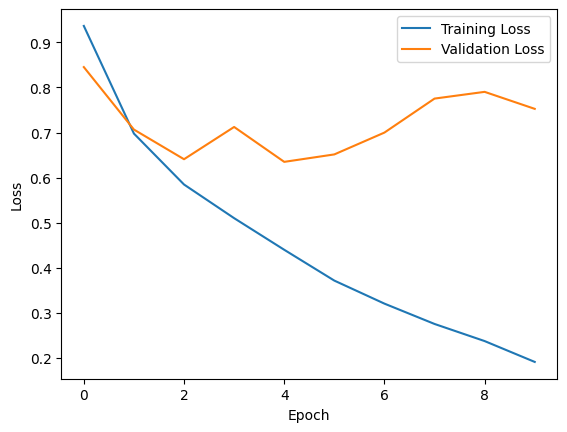

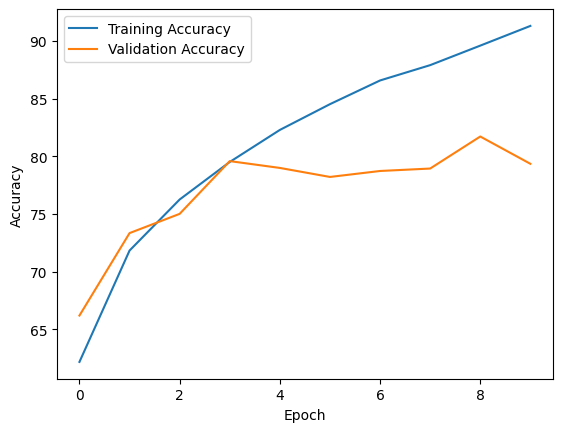

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 297/297 [01:31<00:00,  3.24it/s]

Test Accuracy: 0.8030
Test Precision: 0.8078
Test Recall: 0.8030
Test F1-score: 0.8024

              precision    recall  f1-score   support

       Anger       0.72      0.88      0.79       916
       Bored       0.81      0.96      0.88      1098
     Disgust       0.54      0.63      0.58       291
        Fear       0.57      0.62      0.60       308
       Happy       0.84      0.76      0.80      1914
     Neutral       0.80      0.73      0.77      2226
    Question       0.91      0.94      0.93      1139
         Sad       0.86      0.73      0.79       857
    Surprise       0.83      0.80      0.82       728

    accuracy                           0.80      9477
   macro avg       0.76      0.78      0.77      9477
weighted avg       0.81      0.80      0.80      9477



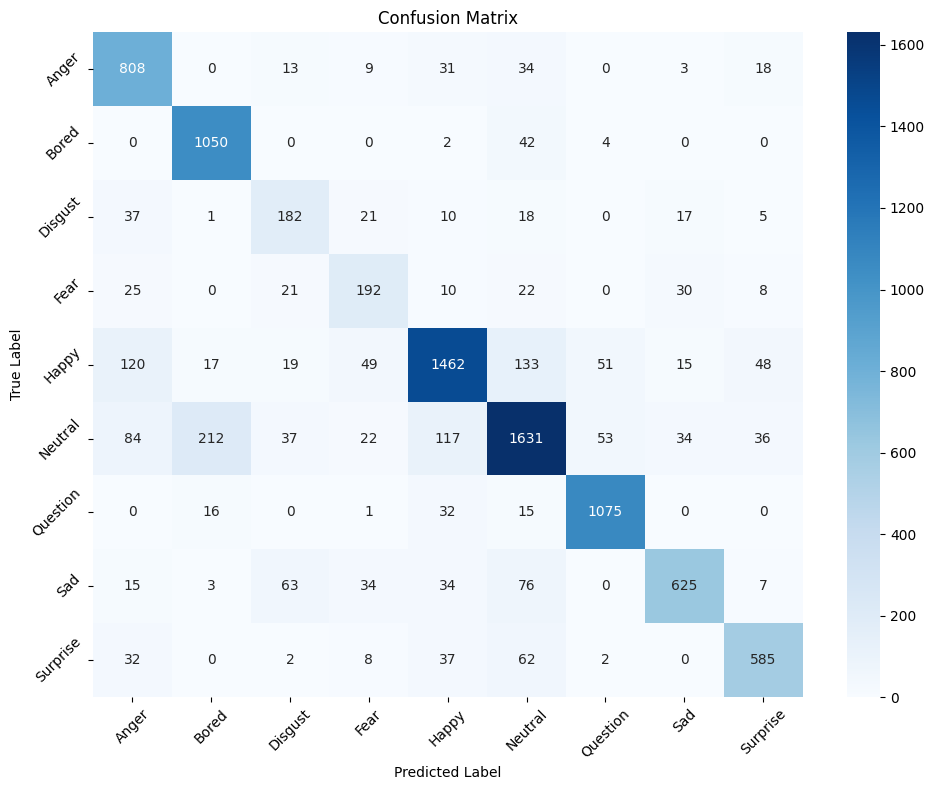

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)